In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, recall_score, make_scorer

%run functions.ipynb

In [2]:
#import data
orig_data = pd.read_csv('../Data/BankChurnersEval.csv')
X_pre = orig_data.iloc[:,2:-1]
X = pd.get_dummies(X_pre, drop_first=True)
y = np.where(orig_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)
orig_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,818903583,Existing Customer,44,M,5,Uneducated,Divorced,$60K - $80K,Blue,39,...,2,0,16034.0,1597,14437.0,0.775,3628,59,0.903,0.100
1,715150983,Attrited Customer,44,F,3,Unknown,Single,Unknown,Blue,34,...,3,3,26021.0,0,26021.0,1.040,8898,60,0.538,0.000
2,789180933,Existing Customer,37,F,3,High School,Single,Less than $40K,Blue,26,...,1,2,2917.0,2216,701.0,0.810,4524,67,0.489,0.760
3,717667833,Existing Customer,34,M,1,Graduate,Married,$40K - $60K,Blue,36,...,2,3,3735.0,1285,2450.0,1.034,1877,33,1.200,0.344
4,714745608,Existing Customer,51,F,4,High School,Single,Less than $40K,Blue,33,...,4,3,3068.0,2071,997.0,0.854,5524,71,0.972,0.675


In [3]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
# Define pipeline
over = SMOTE(random_state=0)
under = RandomUnderSampler(random_state=0)
decision_tree = DecisionTreeClassifier(random_state=0)
steps = [('over', over), 
         ('under', under),
         ('classifier', decision_tree)]
model = Pipeline(steps=steps)

In [5]:
# Define parameter grid
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']}

In [6]:
# Define recall as the scoring metric
recall_scorer = make_scorer(recall_score, average='binary')

In [7]:
print("Tuned Decision Tree test results")

Tuned Decision Tree test results


In [8]:
# Perform the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=recall_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE(random_state=0)),
                                       ('under',
                                        RandomUnderSampler(random_state=0)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30, 40, 50],
                         'classifier__max_features': [None, 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(recall_score, average=binary), verbose=2)

In [9]:
# Check the best parameters
print("Best parameters found: ")
print(pd.Series(grid_search.best_params_))

Best parameters found: 
classifier__criterion            gini
classifier__max_depth              10
classifier__max_features         None
classifier__min_samples_leaf        1
classifier__min_samples_split       2
dtype: object


In [10]:
# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

In [11]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Existing Customer', 'Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.96      0.94      0.95      1787
Attrited Customer       0.72      0.81      0.77       340

         accuracy                           0.92      2127
        macro avg       0.84      0.88      0.86      2127
     weighted avg       0.93      0.92      0.92      2127



In [12]:
results = pd.DataFrame(zip(y_test, y_pred_prob), columns=['actual','confidence'])
results_df = pd.DataFrame()

for prob in range(0,65,5):
    col_name = "threshold_" + str(prob)
    results[prob] = results['confidence'] > (prob/100)
    cm = confusion_matrix_class(confusion_matrix(results['actual'], results[prob]),inverse=True)
    #add record to test results df
    new_record = create_results_record(label=col_name,  
                                       cm=cm)
    results_df = pd.concat([results_df, pd.DataFrame([new_record])], ignore_index=True).drop_duplicates()
    
print(results_df.to_string())

           label  accuracy  precision  recall     F1   tp   fp  fn    tn  pred_pos  pred_neg  act_pos  act_neg  total
0    threshold_0     0.798      0.434   0.868  0.578  295  385  45  1402       680      1447      340     1787   2127
1    threshold_5     0.921      0.722   0.824  0.769  280  108  60  1679       388      1739      340     1787   2127
2   threshold_10     0.921      0.722   0.824  0.769  280  108  60  1679       388      1739      340     1787   2127
3   threshold_15     0.921      0.722   0.824  0.769  280  108  60  1679       388      1739      340     1787   2127
4   threshold_20     0.921      0.723   0.821  0.769  279  107  61  1680       386      1741      340     1787   2127
5   threshold_25     0.921      0.723   0.821  0.769  279  107  61  1680       386      1741      340     1787   2127
6   threshold_30     0.921      0.723   0.821  0.769  279  107  61  1680       386      1741      340     1787   2127
7   threshold_35     0.921      0.722   0.818  0.767  27

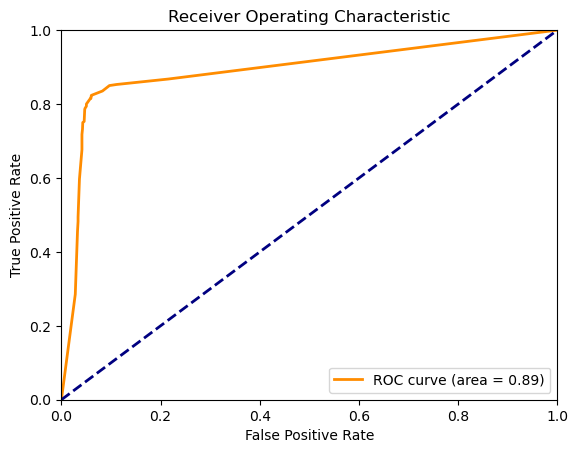

In [13]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

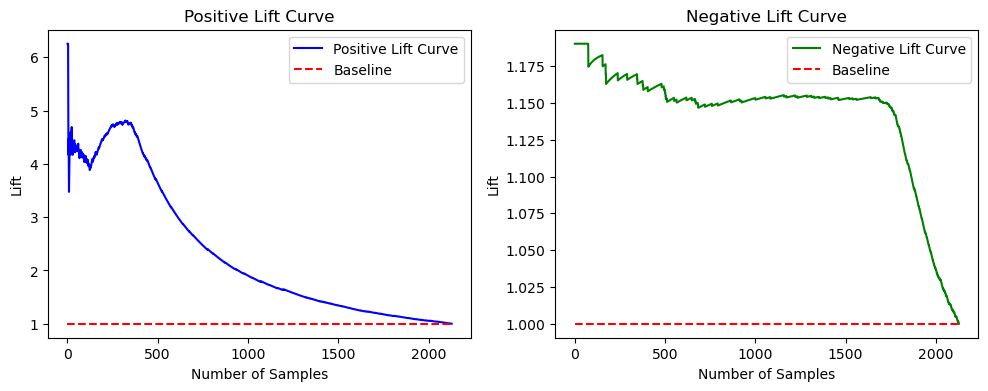

In [14]:
# Plot the lift curves
plot_lift_curves(y_test, y_pred_prob)

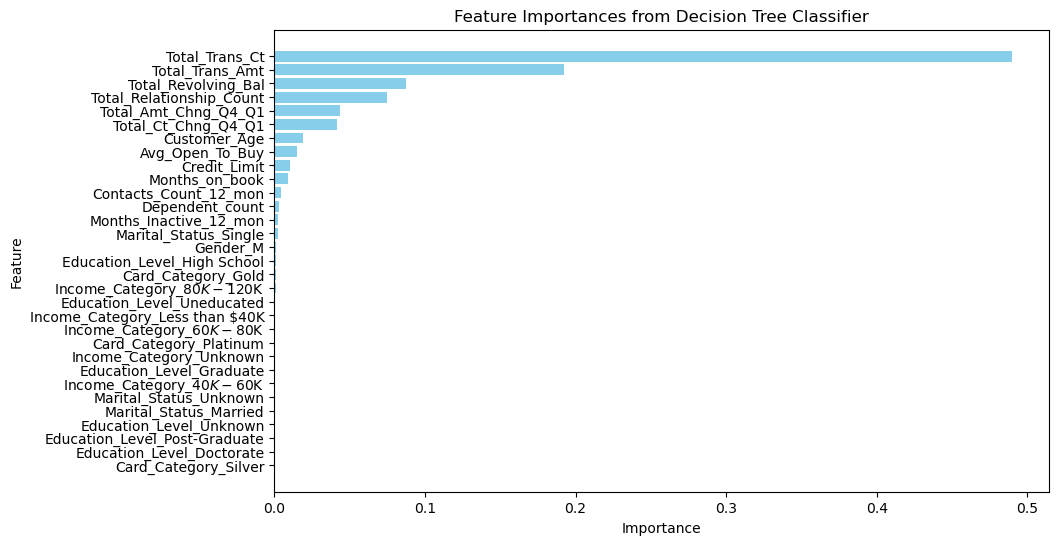

In [15]:
# Get feature importances
classifier = best_model.named_steps['classifier']
feature_importances = classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [16]:
feature_importances_df

,feature,importance
11,Total_Trans_Ct,0.490033
10,Total_Trans_Amt,0.192168
7,Total_Revolving_Bal,0.087604
3,Total_Relationship_Count,0.075137
9,Total_Amt_Chng_Q4_Q1,0.043352
12,Total_Ct_Chng_Q4_Q1,0.041529
0,Customer_Age,0.018953
8,Avg_Open_To_Buy,0.014804
6,Credit_Limit,0.010246
2,Months_on_book,0.008868
